# EE Authentication

In [1]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()


In [2]:
import geemap
import json
from ipyleaflet import GeoJSON, Marker, MarkerCluster
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from skimage import exposure
import cv2

In [3]:
def create_bounding_box(point: ee.Geometry.Point, diameter: float):
    intermediate_circle = point.buffer(diameter/2.0, 0.0)
    return intermediate_circle.bounds()

In [4]:
tokio = ee.Geometry.Point([139.6503, 35.6762])
#Map.centerObject(tokio, 9)
#Map.add_marker([35.6762, 139.6503])

# Combine LANDSAT 5 and LANDSAT 7
We first compare different bands in 1999 to verify the data accuracy and then move on towards combining both datasets into one large dataset
## Our Mapping of Bands

In [5]:
LC8_MAPPING = {
    "B1": "B2",
    "B2": "B3",
    "B3": "B4",
    "B4": "B5",
    "B5": "B6",
    "B7": "B7"
}

LC7_MAPPING = {
    "B1": "B1",
    "B2": "B2",
    "B3": "B3",
    "B4": "B4",
    "B5": "B5",
    "B7": "B7"
}

LC5_MAPPING = {
    "B1": "B1",
    "B2": "B2",
    "B3": "B3",
    "B4": "B4",
    "B5": "B5",
    "B7": "B7"
}

## Accuracy Comparison of LANDSAT 5 and 7
We compare the similarity of LANDSAT 5 and 7 by computing the MSE between the individual bands in the area of Tokio
Below one can find the Bands definition in LANDSAT5 standart

In [6]:
SELECTED_BANDS = ["B1", "B2", "B3", "B4", "B5", "B7"]
BOUNDING_BOX = create_bounding_box(tokio, 15000)

LANDSAT_5 = "LANDSAT/LT05/C02/T1_TOA"
LANDSAT_5_START = 1984
LANDSAT_5_END = 2000

LANDSAT_7 = "LANDSAT/LE07/C02/T1_TOA"
LANDSAT_7_START = 2000
LANDSAT_7_END = 2012

LANDSAT_8 = "LANDSAT/LC08/C02/T1_TOA"
LANDSAT_8_START = 2013
LANDSAT_8_END = 2022

In [7]:
def compute_error_bounding_box(bounding_box, image_ls_5, image_ls_7, band, mapping_ls_5=None, mapping_ls_7=None):
    if mapping_ls_5 is None:
        numpy_ls_5 = geemap.ee_to_numpy(image_ls_5, region=bounding_box, bands=[band], default_value=10)
    else:
        numpy_ls_5 = geemap.ee_to_numpy(image_ls_5, region=bounding_box, bands=[mapping_ls_5[band]], default_value=10)
    
    if mapping_ls_7 is None:
        numpy_ls_7 = geemap.ee_to_numpy(image_ls_7, region=bounding_box, bands=[band], default_value=10)
    else:
        numpy_ls_7 = geemap.ee_to_numpy(image_ls_7, region=bounding_box, bands=[mapping_ls_7[band]], default_value=10)
    
    if numpy_ls_5 is None or numpy_ls_7 is None:
        raise Exception("Could not create numpy array")
    return np.linalg.norm((numpy_ls_7 - numpy_ls_5).flatten(), 2) / (numpy_ls_7.shape[0]*numpy_ls_7.shape[1])


def compute_errors_per_year(bounding_box, year_start=1999, year_end=2010, 
                            LS_OLD=LANDSAT_5, LS_NEW=LANDSAT_7, mapping_old=None, mapping_new=None):
    error_years = []
    years = []
    for year in range(year_start, year_end):
        print(year)
        image_ls_5 = (ee.ImageCollection(LS_OLD)
                        .filterBounds(tokio)
                        .filterDate(f'{year}-01-01', f'{year}-12-31')
                        .sort('CLOUD_COVER')
                        .first())
        image_ls_7 = (ee.ImageCollection(LS_NEW)
                        .filterBounds(tokio)
                        .filterDate(f'{year}-01-01', f'{year}-12-31')
                        .sort('CLOUD_COVER')
                        .first())
        print("Extracting Bands")
        try:
            error_bounds = [compute_error_bounding_box(bounding_box, image_ls_5, image_ls_7, band, mapping_ls_5=mapping_old, mapping_ls_7=mapping_new) 
                        for band in SELECTED_BANDS]
            error_years.append(error_bounds)
            years.append(year)
        except:
            print("Could not parse year propable dataleck") 
    return error_years, years

#error_years, years = compute_errors_per_year(BOUNDING_BOX, mapping_new=LC7_MAPPING, mapping_old=LC5_MAPPING)

In [8]:
#error_years = np.asarray(error_years)
#for i in range(len(SELECTED_BANDS)):
#    plt.plot(years, error_years[:, i], label=SELECTED_BANDS[i])
#plt.xticks(years)
#plt.legend()
#plt.show()

## Qualitative Assesment for year 2003 
Since we saw that the MSE between the two datasets increased for 2003, we checked the quality in this particular region

In [ ]:
def plot_for_year(bounding_box, year=1999, LS_OLD=LANDSAT_5, LS_NEW=LANDSAT_7, band="B1"):
    image_ls_7 = (
        ee.ImageCollection(LS_OLD)
        .filterBounds(tokio)
        .filterDate(f'{year}-01-01', f'{year}-01-31')
        .sort('CLOUD_COVER')
        .first()

    )

    image_ls_5 = (
        ee.ImageCollection(LS_NEW)
        .filterBounds(tokio)
        .filterDate(f'{year}-01-01', f'{year}-01-31')
        .sort('CLOUD_COVER')
        .first()

    )

    numpy_ls_5 = geemap.ee_to_numpy(image_ls_5, region=bounding_box, bands=[LC5_MAPPING[band]], default_value=0.0)
    numpy_ls_7 = geemap.ee_to_numpy(image_ls_7, region=bounding_box, bands=[LC7_MAPPING[band]], default_value=0.0)
    plt.title(f"{band} LANDSAT 7 {year}")
    plt.imshow(numpy_ls_7)
    plt.colorbar()
    plt.show()

    plt.title(f"{band} LANDSAT 5 {year}")
    plt.imshow(numpy_ls_5)
    plt.colorbar()
    plt.show()
#plot_for_year(BOUNDING_BOX, year=1999)

In [ ]:
#plot_for_year(BOUNDING_BOX, year=2003)

We can conclude, that apperantly there is a data leck in LANDSAT 5 for the region of tokio in 2003, hence it is sensible to use LANDSAT7 as soon as it is available.
We can see from the years 1999-2002 that there is a small error, hence we can combine the two datasets without destroying the correlation

In [18]:
def rename_LS_8(image):
    bands = list(LC8_MAPPING.values())
    new_bands = list(LC8_MAPPING.keys())
    return image.select(bands + ["QA_PIXEL"]).rename(new_bands + ["QA_PIXEL"])

def rename_LS_7(image):
    bands = list(LC7_MAPPING.keys())
    new_bands = list(LC7_MAPPING.values())
    return image.select(bands + ["QA_PIXEL"]).rename(new_bands + ["QA_PIXEL"])

def rename_LS_5(image):
    bands = list(LC5_MAPPING.values())
    new_bands = list(LC5_MAPPING.keys())
    return image.select(bands + ["QA_PIXEL"]).rename(new_bands + ["QA_PIXEL"])


image_ls_5 = (ee.ImageCollection(LANDSAT_5)
                .filterDate(f'{LANDSAT_5_START}-01-01', f'{LANDSAT_5_END}-12-31')
                .map(rename_LS_5))

image_ls_7 = (ee.ImageCollection(LANDSAT_7)
                .filterDate(f'{LANDSAT_7_START}-01-01', f'{LANDSAT_7_END}-12-31')
                .map(rename_LS_7))

image_ls_8 = (ee.ImageCollection(LANDSAT_8)
                .filterDate(f'{LANDSAT_8_START}-01-01', f'{LANDSAT_8_END}-12-31')
                .map(rename_LS_8))

COMBINED_LANDSAT = ee.ImageCollection(image_ls_5.merge(image_ls_7).merge(image_ls_8))

In [10]:
js_snippet= """
var kernelSize = 25;// Tried with 5, 10, 20, 30
var kernel = ee.Kernel.square(kernelSize * 30, 'meters', false);

var GapFill = function(image) {
  var start = image.date().advance(-1, 'year');
  var end = image.date().advance(1, 'year');
  var fill = l7.filterDate(start, end).median();
  var regress = fill.addBands(image); 
  var regress1 = regress.select(regress.bandNames().sort());
  var fit = regress1.reduceNeighborhood(ee.Reducer.linearFit().forEach(image.bandNames()), kernel, null, false);
  var offset = fit.select('.*_offset');
  var scale = fit.select('.*_scale');
  var scaled = fill.multiply(scale).add(offset);
  return image.unmask(scaled, true);
};
"""
#geemap.js_snippet_to_py(js_snippet)

In [11]:
def mask_cloud_LANDSAT457(image):
    qa = image.select('QA_PIXEL')
    # If the cloud bit (5) is set and the cloud confidence (7) is high
    # or the cloud shadow bit is set (3), then it's a bad pixel.
    cloud = qa.bitwiseAnd(1 << 5) \
                  .And(qa.bitwiseAnd(1 << 7)) \
                  .Or(qa.bitwiseAnd(1 << 3))
    # Remove edge pixels that don't occur in all bands
    mask2 = image.mask().reduce(ee.Reducer.min())
    return image.updateMask(cloud.Not()).updateMask(mask2)

def mask_cloud_LANDSAT8(image):
    """
    Mask clouds and cloud shadows from image
    """
    cloud_shadow_bit_mask = (1 << 3)
    cloud_bit_mask = (1 << 5)

    qa = image.select("QA_PIXEL")
    
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
    .And(qa.bitwiseAnd(cloud_bit_mask).eq(0))
    return image.updateMask(mask)


In [12]:
MIN_SCALE = 1/3
MAX_SCALE = 3
MIN_NEIGHBORS = 144

# Apply the USGS L7 Phase-2 Gap filling protocol, using a single kernel size. #
# STRG+C STRG+V from => https://gis.stackexchange.com/questions/264061/ls7-filling-the-gaps-image-with-google-earth-engine
# We will use this as a baseline for now, maybe upscale later to a larger area or use CNN or other img reconstruction algorithms
# Asessment of th
def gap_fill(src, fill, kernelSize):
    kernel = ee.Kernel.square(kernelSize * 30, "meters", False)

    # Find the pixels common to both scenes.
    common = src.mask().And(fill.mask())
    fc = fill.updateMask(common)
    sc = src.updateMask(common)

    # Find the primary scaling factors with a regression.
    # Interleave the bands for the regression.  This assumes the bands have the same names.
    regress = fc.addBands(sc)
    regress = regress.select(regress.bandNames().sort())
    fit = regress.reduceNeighborhood(ee.Reducer.linearFit().forEach(src.bandNames()),  kernel, None, False)
    offset = fit.select(".*_offset")
    scale = fit.select(".*_scale")

    # Find the secondary scaling factors using just means and stddev
    reducer = ee.Reducer.mean().combine(ee.Reducer.stdDev(), None, True)
    src_stats = src.reduceNeighborhood(reducer, kernel, None, False)
    fill_stats = fill.reduceNeighborhood(reducer, kernel, None, False)
    scale2 = src_stats.select(".*stdDev").divide(fill_stats.select(".*stdDev"))
    offset2 = src_stats.select(".*mean").subtract(fill_stats.select(".*mean").multiply(scale2))

    invalid = scale.lt(MIN_SCALE).Or(scale.gt(MAX_SCALE))
    scale = scale.where(invalid, scale2)
    offset = offset.where(invalid, offset2)

    # When all else fails, just use the difference of means as an offset.
    invalid2 = scale.lt(MIN_SCALE).Or(scale.gt(MAX_SCALE))
    scale = scale.where(invalid2, 1)
    offset = offset.where(invalid2, src_stats.select(".*mean").subtract(fill_stats.select(".*mean")))

    # Apply the scaling and mask off pixels that didn't have enough neighbors.
    count = common.reduceNeighborhood(ee.Reducer.count(), kernel, None, True, "boxcar")
    scaled = fill.multiply(scale).add(offset) \
      .updateMask(count.gte(MIN_NEIGHBORS))

    return src.unmask(scaled, True)

In [36]:
amberg = ee.Geometry.Point([139.6380, 35.4437]) # Coord format: E, N
MUNICH_BOUNDING_BOX = create_bounding_box(amberg, 14000)

year = 2015

ls7_read = (ee.ImageCollection(LANDSAT_7)
            .filterDate(f'{year}-01-01', f'{year}-12-31')
            .filterBounds(MUNICH_BOUNDING_BOX))

ls7_read = (ls7_read
            .filter(ee.Filter.lessThan('CLOUD_COVER_LAND', 25))
            .map(mask_cloud_LANDSAT8)
            .select("B1", "B2", "B3")
            .median()
            .reproject(ls7_read.first().select("B1").projection())
          )

ls8_read = (ee.ImageCollection(LANDSAT_8)
            .filterDate(f'{year}-01-01', f'{year}-12-31')
            .filterBounds(MUNICH_BOUNDING_BOX))
ls8_read = (ls8_read
            .filter(ee.Filter.lessThan('CLOUD_COVER_LAND', 25))
            .map(mask_cloud_LANDSAT8)
            .select("B2", "B3", "B4")
            .median()
            .reproject(ls8_read.first().select("B1").projection())
          )

numpy_ls_ls8 = geemap.ee_to_numpy(ls8_read, region=MUNICH_BOUNDING_BOX, bands=["B2", "B3", "B4"], default_value=0.0)
numpy_ls_ls7 = geemap.ee_to_numpy(ls7_read, region=MUNICH_BOUNDING_BOX, bands=["B1", "B2", "B3"], default_value=0.0)

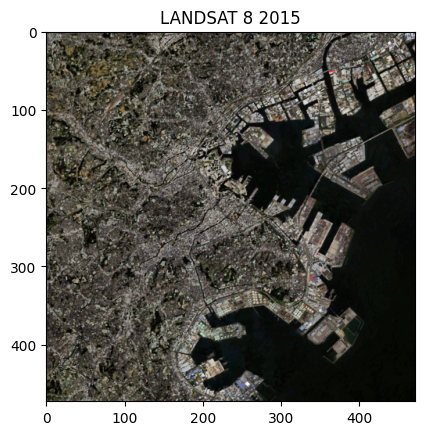

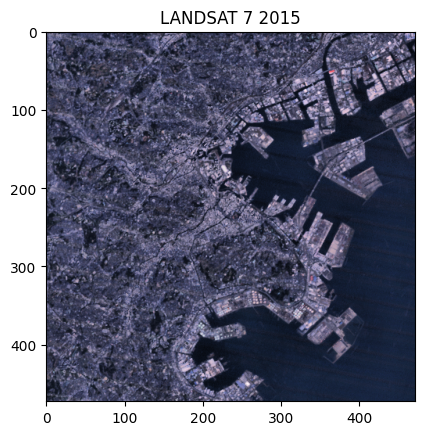

In [37]:
year_frame = numpy_ls_ls8

def norm(band):
    band_min, band_max = band.min(), band.max()
    band_ = ((band - band_min)/(band_max - band_min))    
    return band_

def plot_image_rgb(year_frame, title):
    r = norm(year_frame[:, :, 2])
    g = norm(year_frame[:, :, 1])
    b = norm(year_frame[:, :, 0])

    img = np.dstack((r, g, b))

    img = exposure.equalize_adapthist(img, clip_limit=0.02)
    plt.imshow(img)
    plt.title(title)
    plt.show()

plot_image_rgb(numpy_ls_ls8, f"LANDSAT 8 {year}")
plot_image_rgb(numpy_ls_ls7, f"LANDSAT 7 {year}")


In [47]:
city = ee.Geometry.Point([121.7392, 25.1276]) # Coord format: E, N
CITY_NAME = "Keelung"
MAX_CLOUD_COVER = 10
BOUNDING_BOX = create_bounding_box(city, 10000)

bands_over_years = []
for year in range(1985, 2022):
    print(f"At Year: {year}")
    ls7_read = (COMBINED_LANDSAT
            .filterDate(f'{year}-01-01', f'{year}-12-31')
            .filterBounds(BOUNDING_BOX))
    if year >= LANDSAT_8_START:
        ls7_read = (ls7_read
                .filter(ee.Filter.lessThan('CLOUD_COVER', MAX_CLOUD_COVER))
                .map(mask_cloud_LANDSAT8)
                .select("B1", "B2", "B3")
                .median()
                .reproject(ls7_read.first().select("B1").projection())
              )
    else:
        ls7_read = (ls7_read
                .filter(ee.Filter.lessThan('CLOUD_COVER', MAX_CLOUD_COVER))
                .map(mask_cloud_LANDSAT457)
                .select("B1", "B2", "B3")
                .median()
                .reproject(ls7_read.first().select("B1").projection())
              )
        
    # TODO write combination script that allows us to have no default values
    numpy_ls = geemap.ee_to_numpy(ls7_read, region=BOUNDING_BOX, bands=["B1", "B2", "B3"], default_value=0.0)
    bands_over_years.append(numpy_ls)

At Year: 1985
Image.select: Parameter 'input' is required.
At Year: 1986
At Year: 1987
At Year: 1988
At Year: 1989
Image.select: Pattern 'B1' did not match any bands.
At Year: 1990
At Year: 1991


KeyboardInterrupt: 

36 36
Done!


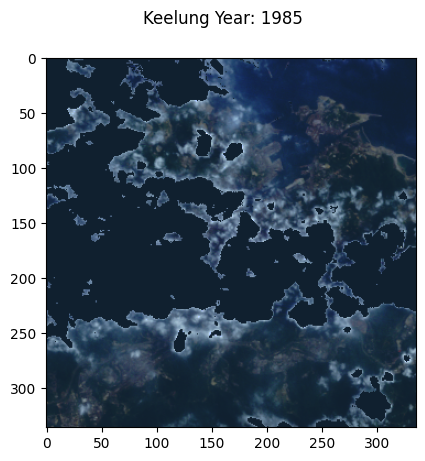

In [46]:
YEAR_START = 1986
YEAR_END = 2022
bands_over_years_ = bands_over_years#[1:]
print(len(bands_over_years_), YEAR_END-YEAR_START)
fig = plt.figure()
ax = plt.axes()
years = list(range(YEAR_START, YEAR_END))


year_frame = bands_over_years_[-1]
r = norm(year_frame[:, :, 2])
g = norm(year_frame[:, :, 1])
b = norm(year_frame[:, :, 0])
IMG_2022 = exposure.equalize_adapthist(np.dstack([r, g, b]), clip_limit=0.02)

def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

def animate(year_idx):
    year_frame = bands_over_years_[year_idx]
    

    r = norm(year_frame[:, :, 2])
    g = norm(year_frame[:, :, 1])
    b = norm(year_frame[:, :, 0])
    img = np.dstack([r, g, b])
    img = exposure.match_histograms(img, IMG_2022, channel_axis=-1)
    
    ax.imshow(img)
    fig.suptitle(f"{CITY_NAME} Year: {years[year_idx]}")
    
    
ani = FuncAnimation(fig, animate, interval = 500, frames = YEAR_END-YEAR_START, repeat = False)


ani.save(f'city_plots/{CITY_NAME}_plot.mp4')
print("Done!")

In [115]:
year = 1985
ls5_read = (ee.ImageCollection(LANDSAT_5)
            .filterDate(f'{year}-01-01', f'{year}-12-31')
            .filterBounds(AMBERG_BOUNDING_BOX))

ls5_read = (ls5_read
            .map(mask_cloud_LANDSAT457)
            .select("B1", "B2", "B3")
            .median()
            .reproject(ls5_read.first().select("B1").projection())
            .focal_median()
          )

numpy_ls = geemap.ee_to_numpy(ls5_read, region=AMBERG_BOUNDING_BOX, bands=["B1", "B2", "B3"], default_value=0.0)

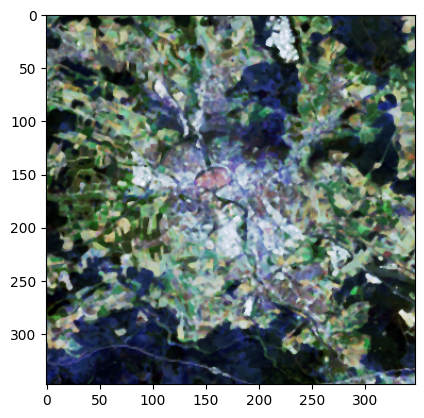

In [116]:
r = norm(year_frame[:, :, 2])
g = norm(year_frame[:, :, 1])
b = norm(year_frame[:, :, 0])
img = np.dstack([r, g, b])
img = exposure.match_histograms(img, IMG_2022, channel_axis=-1)
    
plt.imshow(img)